In [321]:
!pip show torch

Name: torch
Version: 2.8.0+cu126
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-cufile-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, setuptools, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchvision


In [322]:
import torch
from sklearn.datasets import load_iris
import pandas as pd

data = load_iris(as_frame=True)["frame"]

In [323]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(42)

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(4, 12),
        nn.ReLU(),

        nn.Linear(12, 12),

        nn.Linear(12, 3),
    )

  def forward(self, x):
    return self.layers(x)

class MyDataset(torch.utils.data.Dataset):
  def __init__(self, X, y) -> None:
    super().__init__()
    self.X = torch.FloatTensor(X)
    self.y = torch.LongTensor(y.values)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [324]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
feature_labels = data.columns.to_list()
feature_labels.remove("target")
X_train, X_test, y_train, y_test = train_test_split(data[feature_labels], data["target"], test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [325]:
y_train[y_train == 0].count()

np.int64(31)

In [326]:
train = MyDataset(X_train, y_train)
test = MyDataset(X_test, y_test)
g = torch.Generator()
g.manual_seed(42)
train_dataloader = torch.utils.data.DataLoader(train, batch_size=25, shuffle=True, num_workers=0)

Эпоха 10: 100%|██████████| 5/5 [00:00<00:00, 700.31it/s]


<Axes: >

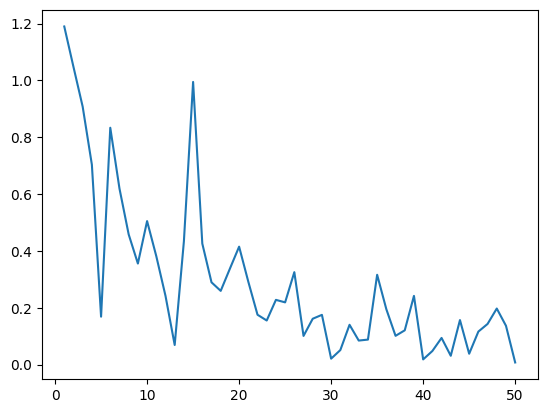

In [327]:
from tqdm import tqdm
import seaborn as sns

losses = []
model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=1)
num_epochs = 10

for ep in range(num_epochs):
  pbar = tqdm(train_dataloader, desc=f"Эпоха {ep + 1}", total=len(train_dataloader), leave=True)
  model.train()
  for x, y in pbar:
    model_res = model(x)
    loss = F.cross_entropy(model_res, y)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  model.eval()

sns.lineplot(x=range(1, len(losses)+1), y=list(losses))

In [328]:
from sklearn.metrics import accuracy_score
softmax = nn.Softmax(dim=1)
X_test = torch.FloatTensor(X_test)
y_pred = torch.argmax(softmax(model(X_test)), axis=1)
print(accuracy_score(y_test, y_pred))

1.0
